# Brain Tumor Detector


 **This Notebook uses a pre-trained inceptionV3 model for the classification task**

 - augmentation: random flip and random contrast

 - no class weights

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [2]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=3a1b5db2-8bf1-4bb5-9a11-9d3d835c5ac5
To: /content/brain_tumor.zip
100% 156M/156M [00:01<00:00, 152MB/s]


In [3]:
!unzip -q brain_tumor.zip

In [4]:
ls -l

total 152156
-rw-r--r-- 1 root root 155791278 Apr  5 09:15 brain_tumor.zip
drwxr-xr-x 1 root root      4096 Apr  3 13:25 sample_data/
drwxr-xr-x 6 root root      4096 Apr  5 09:15 Testing/
drwxr-xr-x 6 root root      4096 Apr  5 09:15 Training/


In [5]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (67.6 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121753 files and directories currently instal

In [6]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

./Training/
├── glioma  [1321 entries exceeds filelimit, not opening dir]
├── meningioma  [1339 entries exceeds filelimit, not opening dir]
├── notumor  [1595 entries exceeds filelimit, not opening dir]
└── pituitary  [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

./Testing/
├── glioma  [300 entries exceeds filelimit, not opening dir]
├── meningioma  [306 entries exceeds filelimit, not opening dir]
├── notumor  [405 entries exceeds filelimit, not opening dir]
└── pituitary  [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Load Dependencies

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.15.0


## Utility functions to create dataset generators

In [9]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [10]:
train_ds, val_ds = prepare_train_and_val_datasets()


train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

In [11]:
from tensorflow.keras import  layers, models
import keras

In [12]:
model_name = 'InceptionV3'

In [13]:
#### Use pre-trained inceptionV3 model

model_IN = keras.applications.InceptionV3(include_top=False,
                                       weights="imagenet",
                                       input_shape=IMG_SHAPE,
                                       classes=4,
                                       classifier_activation='softmax'
                                       )

model_IN.trainable = False


87910968/87910968 [==============================] - 0s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_ds))
image_batch.shape

TensorShape([32, 128, 128, 3])

In [16]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = model_IN(image_batch)
print(feature_batch.shape)

(32, 2, 2, 2048)


In [18]:
for layer in model_IN.layers:
  print(layer.name, '->', layer.trainable)

input_1 -> False
conv2d -> False
batch_normalization -> False
activation -> False
conv2d_1 -> False
batch_normalization_1 -> False
activation_1 -> False
conv2d_2 -> False
batch_normalization_2 -> False
activation_2 -> False
max_pooling2d -> False
conv2d_3 -> False
batch_normalization_3 -> False
activation_3 -> False
conv2d_4 -> False
batch_normalization_4 -> False
activation_4 -> False
max_pooling2d_1 -> False
conv2d_8 -> False
batch_normalization_8 -> False
activation_8 -> False
conv2d_6 -> False
conv2d_9 -> False
batch_normalization_6 -> False
batch_normalization_9 -> False
activation_6 -> False
activation_9 -> False
average_pooling2d -> False
conv2d_5 -> False
conv2d_7 -> False
conv2d_10 -> False
conv2d_11 -> False
batch_normalization_5 -> False
batch_normalization_7 -> False
batch_normalization_10 -> False
batch_normalization_11 -> False
activation_5 -> False
activation_7 -> False
activation_10 -> False
activation_11 -> False
mixed0 -> False
conv2d_15 -> False
batch_normalization_1

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [20]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
dense_output = dense_layer(feature_batch_average)
prediction_batch = prediction_layer(dense_output)
print(prediction_batch.shape)

(32, 1)


In [21]:
inputs = tf.keras.Input(shape=IMG_SHAPE)

In [22]:
res_model_fm = model_IN(inputs, training=False)

feature_vecs = tf.keras.layers.GlobalAveragePooling2D()(res_model_fm)

dense1 = tf.keras.layers.Dense(256)(feature_vecs)

drop1 = tf.keras.layers.Dropout(0.2)(dense1)

outputs = tf.keras.layers.Dense(4, activation='softmax')(drop1)

model = tf.keras.Model(inputs, outputs)

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [24]:
for layer in model.layers:
    print(layer.name, '->', layer.trainable)

input_2 -> True
inception_v3 -> False
global_average_pooling2d_1 -> True
dense_2 -> True
dropout -> True
dense_3 -> True


In [37]:
initial_epochs = 30


history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
143/143 [==============================] - 11s 36ms/step - loss: 3.1523 - sparse_categorical_accuracy: 0.7547 - val_loss: 2.2545 - val_sparse_categorical_accuracy: 0.8231
Epoch 2/30
143/143 [==============================] - 11s 36ms/step - loss: 2.8594 - sparse_categorical_accuracy: 0.7398 - val_loss: 2.9554 - val_sparse_categorical_accuracy: 0.8004
Epoch 3/30
143/143 [==============================] - 11s 36ms/step - loss: 4.3787 - sparse_categorical_accuracy: 0.6996 - val_loss: 2.7616 - val_sparse_categorical_accuracy: 0.8170
Epoch 4/30
143/143 [==============================] - 10s 37ms/step - loss: 2.8533 - sparse_categorical_accuracy: 0.7595 - val_loss: 1.9933 - val_sparse_categorical_accuracy: 0.8354
Epoch 5/30
143/143 [==============================] - 10s 41ms/step - loss: 2.4582 - sparse_categorical_accuracy: 0.7593 - val_loss: 2.4727 - val_sparse_categorical_accuracy: 0.8205
Epoch 6/30
143/143 [==============================] - 10s 36ms/step - loss: 2.8425 - spars

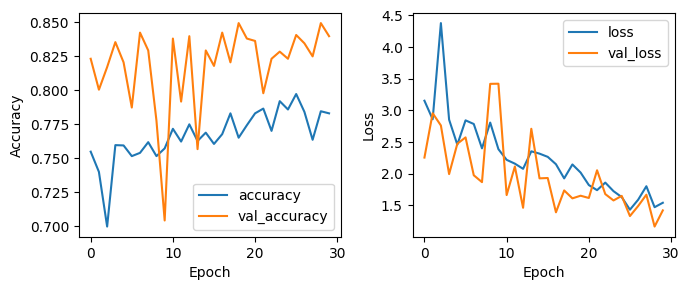

In [38]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(history.history['sparse_categorical_accuracy'], label='accuracy')
ax[0].plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right');

ax[1].plot(history.history['loss'], label='loss')
ax[1].plot(history.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right');

fig.tight_layout()
#plt.savefig("./plots/inception_CNN.png", dpi=300, format='png')
plt.show()

In [39]:
y_true, y_pred = eval_model_on_test(model)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 43ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:13,  1.31s/it]

4/4 [==============================] - 0s 27ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:05,  1.50it/s]

4/4 [==============================] - 0s 28ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:03,  2.12it/s]

4/4 [==============================] - 0s 27ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:02<00:02,  2.62it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:02<00:01,  3.15it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:02<00:01,  3.44it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:02<00:01,  3.67it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  4.09it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:03<00:00,  4.42it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:03<00:00,  4.66it/s]

1/1 [==============================] - 0s 32ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:03<00:00,  3.25it/s]


In [40]:
y_pred_class = np.argmax(y_pred,1)
y_pred_class.shape

(1311,)

In [41]:
print(classification_report(y_true, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

      glioma       0.93      0.48      0.63       300
  meningioma       0.62      0.84      0.71       306
     notumor       0.88      0.97      0.92       405
   pituitary       0.92      0.92      0.92       300

    accuracy                           0.81      1311
   macro avg       0.84      0.80      0.80      1311
weighted avg       0.84      0.81      0.81      1311



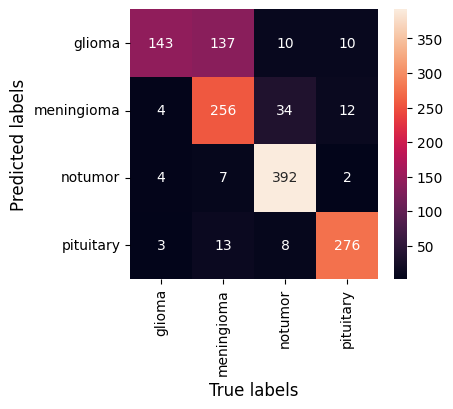

In [42]:
import seaborn as sns

plt.subplots(figsize=(4,3.5))
ax = sns.heatmap(confusion_matrix(y_true, y_pred_class),
            annot=True,
            fmt=".0f",
            xticklabels=classes,
            yticklabels=classes
            );
#ax.set_xticklabels(class_names, rotation=90, size="10")
ax.set_xlabel('True labels', size='12')
ax.set_ylabel('Predicted labels', size='12')
#plt.savefig("./plots/basic_CNN_CM.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, mode='min')

In [33]:
%%time
history = new_model.fit(train_ds,
                        epochs = 20,
                        validation_data = val_ds,
                        callbacks=[checkpoint]
                        )

Epoch 1/20
143/143 [==============================] - ETA: 0s - loss: 6.2200 - sparse_categorical_accuracy: 0.5792

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/143 [==============================] - 23s 79ms/step - loss: 6.2200 - sparse_categorical_accuracy: 0.5792 - val_loss: 3.1025 - val_sparse_categorical_accuracy: 0.7005
Epoch 2/20
143/143 [==============================] - 7s 48ms/step - loss: 2.6905 - sparse_categorical_accuracy: 0.7074 - val_loss: 1.9276 - val_sparse_categorical_accuracy: 0.7601
Epoch 3/20
143/143 [==============================] - 7s 51ms/step - loss: 2.1291 - sparse_categorical_accuracy: 0.7475 - val_loss: 2.3569 - val_sparse_categorical_accuracy: 0.7434
Epoch 4/20
143/143 [==============================] - 7s 45ms/step - loss: 1.7822 - sparse_categorical_accuracy: 0.7722 - val_loss: 3.5658 - val_sparse_categorical_accuracy: 0.7049
Epoch 5/20
143/143 [==============================] - 8s 56ms/step - loss: 1.3367 - sparse_categorical_accuracy: 0.8066 - val_loss: 1.8364 - val_sparse_categorical_accuracy: 0.7951
Epoch 6/20
143/143 [==============================] - 7s 50ms/step - loss: 1.2715 - sparse_categorical_ac

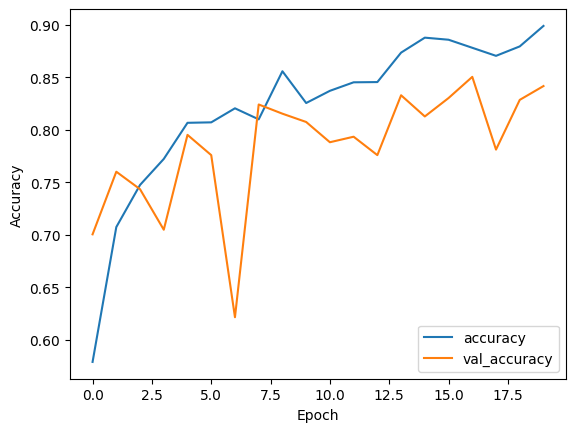

In [36]:

plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

In [37]:
####
y_true, y_pred = eval_model_on_test(new_model)


Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 1s 40ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:02<00:25,  2.56s/it]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:02<00:11,  1.29s/it]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:03<00:07,  1.13it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:03<00:04,  1.43it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:04<00:03,  1.83it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:04<00:02,  2.25it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:04<00:01,  2.65it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:04<00:00,  3.12it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:04<00:00,  3.39it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:05<00:00,  3.64it/s]

1/1 [==============================] - 4s 4s/step


Predicting on Test Data: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


In [ ]:
y_true

array([2, 1, 1, ..., 1, 1, 3], dtype=int32)

In [ ]:
y_pred

array([[1.9264238e-02, 1.9027489e-04, 9.8011851e-01, 4.2695508e-04],
       [1.3821565e-01, 8.6164361e-01, 1.7563190e-05, 1.2311427e-04],
       [1.5857164e-04, 9.8525882e-01, 7.7874074e-03, 6.7951642e-03],
       ...,
       [4.4814902e-03, 9.9350375e-01, 4.5197253e-04, 1.5628889e-03],
       [2.6585598e-04, 9.9904162e-01, 6.3295226e-04, 5.9586640e-05],
       [3.3093311e-03, 1.0492829e-02, 4.3756803e-03, 9.8182213e-01]],
      dtype=float32)

In [38]:
prediction_labels = np.argmax(y_pred, axis=1)
prediction_labels

array([2, 1, 1, ..., 1, 1, 3])

In [39]:
### classification report

print(classification_report(y_true=y_true, y_pred=prediction_labels,
                            target_names=classes))

              precision    recall  f1-score   support

      glioma       0.90      0.53      0.67       300
  meningioma       0.61      0.89      0.72       306
     notumor       0.95      0.95      0.95       405
   pituitary       0.94      0.89      0.92       300

    accuracy                           0.83      1311
   macro avg       0.85      0.82      0.81      1311
weighted avg       0.86      0.83      0.82      1311



In [ ]:
### confusion matrix